In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision.transforms.v2 as tfs

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


from modules.xfeat import XFeat

# XFEAT

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from modules.xfeat import XFeat
xfeat = XFeat()

loading weights from: c:\Users\lolke\Desktop\fine-tuning lightglue\modules\..\weights\xfeat.pt


In [ ]:
img_1 = Image.open("dataset/train/002298.jpg").convert("RGB")
img_1_np = np.array(img_1)
img_1_tensor = torch.from_numpy(img_1_np)


img_1_tensor.shape

img_2 = Image.open("002328.jpg").convert("RGB")
img_2_np = np.array(img_2)
img_2_tensor = torch.from_numpy(img_2_np).permute(2,0,1).unsqueeze(0)
img_2_tensor.shape

In [ ]:
output_1 = xfeat.detectAndCompute(img_1_tensor, top_k=100)[0]
output_2 = xfeat.detectAndCompute(img_2_tensor, top_k=100)[0]

In [ ]:
import matplotlib.pyplot as plt

kpts_1 = output_1['keypoints'].cpu()
kpts_2 = output_2['keypoints'].cpu()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_1)
plt.scatter(
    kpts_1[:,0],
    kpts_1[:,1],
    c='lime',
    s=10,
)
plt.axis('off')  
plt.subplot(1,2,2)
plt.imshow(img_2)
plt.scatter(
    kpts_2[:,0],
    kpts_2[:,1],
    c='lime',
    s=10,
)
plt.axis('off')
plt.show()

# LIGHTERGLUE

In [4]:
from modules.lighterglue import LighterGlue

matcher = LighterGlue().to(device).eval()



Loading LighterGlue weights from: c:\Users\lolke\Desktop\fine-tuning lightglue\modules\..\weights\xfeat-lighterglue.pt
Loaded LightGlue model


In [5]:
W1, H1 = img_1.size
W2, H2 = img_2.size

data = {
    'keypoints0': output_1['keypoints'].unsqueeze(0).to(device),
    'descriptors0': output_1['descriptors'].unsqueeze(0).to(device),
    'image_size0': torch.tensor([[W1, H1]], device=device, dtype=torch.float32),
    
    'keypoints1': output_2['keypoints'].unsqueeze(0).to(device),
    'descriptors1': output_2['descriptors'].unsqueeze(0).to(device),
    'image_size1': torch.tensor([[W2, H2]], device=device, dtype=torch.float32),
}

NameError: name 'img_1' is not defined

In [ ]:
with torch.no_grad():
    matches = matcher(data)

In [ ]:
matches = matches['matches'][0].cpu().numpy()   # (M, 2)
idx0 = matches[:, 0]   # индексы в первом изображении
idx1 = matches[:, 1]   # индексы во втором

# 2) Координаты keypoints
kpts0 = output_1['keypoints'].cpu().numpy()   # (N0, 2)
kpts1 = output_2['keypoints'].cpu().numpy()   # (N1, 2)

mkpts0 = kpts0[idx0]   # (M, 2)
mkpts1 = kpts1[idx1]   # (M, 2)

In [ ]:
h1, w1, _ = img_1_np.shape
h2, w2, _ = img_2_np.shape

canvas = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
canvas[:h1, :w1] = img_1_np
canvas[:h2, w1:w1+w2] = img_2_np

plt.figure(figsize=(12, 6))
plt.imshow(canvas)

for (x0, y0), (x1, y1) in zip(mkpts0, mkpts1):
    plt.plot([x0, x1 + w1], [y0, y1], c='lime', linewidth=0.8, alpha=0.7)

plt.axis('off')
plt.show()

# DATASET

In [49]:
from pathlib import Path
from PIL import Image
import numpy as np
import torch
from modules.dataset.augmentation import AugmentationPipe
import os

class MatcherDataset(torch.utils.data.Dataset):
    """Some Information about MatcherDataset"""
    def __init__(self, device, img_dir: Path, img_size: tuple[int, int] =(1024, 1280), difficulty = 0.1, mode='train'):
        super(MatcherDataset, self).__init__()
        self.img_dir = Path(os.path.join(img_dir,mode))
        self.img_paths = sorted(str(img) for img in self.img_dir.iterdir() if img.suffix.lower() in ['.jpg','.png'])
        self.img_size = img_size
        self.H = img_size[0]
        self.W = img_size[1]
        self.device = device
        self.difficulty = difficulty

        
        self.gomographPipe = AugmentationPipe(
            device=self.device,
            img_dir=str(self.img_dir),
            warp_resolution=self.img_size,
            out_resolution=self.img_size,
            sides_crop=0,
            max_num_imgs=20,
            num_test_imgs=1,
            photometric=False,
            geometric=True,
        ).to(self.device)


    def __getitem__(self, index):
        img = Image.open(self.img_paths[index]).convert('RGB')
        img_np = np.array(img)
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0)  # [1,3,H,W]

        res, ext = self.gomographPipe(img_tensor.to(self.device), self.difficulty, TPS=False)
        H, mask = ext  # H: [B,3,3], mask: [B,H,W]

        # убираем batch
        img0 = img_tensor.squeeze(0)      # [3,H,W]
        img1 = res.squeeze(0)             # [3,H,W]
        H    = H.squeeze(0)               # [3,3]
        mask = mask.squeeze(0)            # [H,W]

        return img0, img1, (H, mask)

    def __len__(self):
        return len(self.img_paths)

In [50]:
dataset = MatcherDataset(device, Path("./dataset"), (1024, 1280), 0.1, "train")

[Synthetic] Found a total of  46  images for training..


loading test: 100%|██████████| 1/1 [00:00<00:00, 153.68it/s]


In [51]:
def configure_dataloaders(device, dir, img_size, difficulty, batch_size, val_batch_size):
    train_dataset = MatcherDataset(device, dir, img_size, difficulty, mode="train")
    val_dataset   = MatcherDataset(device, dir, img_size, difficulty, mode="val")
    test_dataset  = MatcherDataset(device, dir, img_size, difficulty, mode="test")

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset


train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = configure_dataloaders(device, "dataset", (1024, 1280), 0.1, 2, 16)

[Synthetic] Found a total of  46  images for training..


loading test: 100%|██████████| 1/1 [00:00<00:00, 181.36it/s]


[Synthetic] Found a total of  46  images for training..


loading test: 100%|██████████| 1/1 [00:00<00:00, 166.16it/s]


[Synthetic] Found a total of  46  images for training..


loading test: 100%|██████████| 1/1 [00:00<00:00, 196.57it/s]


## ВСЕ ИЗОБРАЖЕНИЯ ВОЗВРАЩАЮТСЯ С ДАТАСЕТА КАК [B, C, H, W]

In [52]:
res = dataset[38]
img0_t = res[0]        # (3, H_out, W_out)
img1_t = res[1]        # (3, H_out, W_out)
H_batched = res[2][0]  # (1, 3, 3)
mask = res[2][1]       # (1, H_out, W_out)

print(img0_t.shape)
print(img1_t.shape)
print(H_batched.shape)
print(mask.shape)

#plt.subplot(1,2,1)
#plt.imshow(np.array(img0_t.permute(1,2,0).cpu()))
#plt.axis('off')
#plt.subplot(1,2,2)
#plt.imshow(np.array(img1_t.permute(1,2,0).cpu()))
#plt.axis('off')

#plt.show()

torch.Size([3, 1024, 1280])
torch.Size([3, 1024, 1280])
torch.Size([3, 3])
torch.Size([1024, 1280])


In [53]:
def configure_dataloaders(device, dir, img_size, difficulty, batch_size, val_batch_size):
    train_dataset = MatcherDataset(device, dir, img_size, difficulty, mode="train")
    val_dataset   = MatcherDataset(device, dir, img_size, difficulty, mode="val")
    test_dataset  = MatcherDataset(device, dir, img_size, difficulty, mode="test")

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset


train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = configure_dataloaders(device, "dataset", (1024, 1280), 0.1, 2, 16)

[Synthetic] Found a total of  46  images for training..


loading test: 100%|██████████| 1/1 [00:00<00:00, 129.69it/s]


[Synthetic] Found a total of  46  images for training..


loading test: 100%|██████████| 1/1 [00:00<00:00, 164.66it/s]


[Synthetic] Found a total of  46  images for training..


loading test: 100%|██████████| 1/1 [00:00<00:00, 181.51it/s]


In [54]:
doutput_1 = None
output_2 = None
Warp = None
Mask = None
Img = None
Res = None

W1 = W2 = 1280
H1 = H2 = 1024
B = 2

for img, res, (warp, mask) in train_loader:
    print(img.shape, 
          res.shape, 
          warp.shape,
          mask.shape, sep='\n')
    output_1 = xfeat.detectAndCompute(img, top_k=100)
    output_2 = xfeat.detectAndCompute(res, top_k=100)
    Img = img
    Res = res
    Warp = warp
    Mask = mask
    print(len(output_1))
    break

def __collect_xfeat_to_batch(xfeat_output, W, H, B):
    kps = []
    dss = []
    sizes = []

    lengths = [sample['keypoints'].shape[0] for sample in xfeat_output]
    M = min(lengths)

    for sample in xfeat_output:
        k = sample['keypoints']
        d = sample['descriptors']

        k = k[:M]
        d = d[:M]

        kps.append(k)
        dss.append(d)
        sizes.append(torch.tensor([W1, H1], dtype=torch.float32, device=k.device))
    
    keypoints   = torch.stack(kps, dim=0)   # [B, M, 2]
    descriptors = torch.stack(dss, dim=0)   # [B, M, D]
    image_size = torch.tensor([[H, W]] * B, dtype=torch.float32, device=img.device)

    return keypoints, descriptors, image_size

keypoints_0, descriptors_0, image_size_0 = __collect_xfeat_to_batch(output_1, W1, H1, B)
keypoints_1, descriptors_1, image_size_1 = __collect_xfeat_to_batch(output_2, W2, H2, B)

print(image_size_0)
print(image_size_1)

data = {
    'keypoints0': keypoints_0.to(device),
    'descriptors0': descriptors_0.to(device),
    'image_size0': image_size_0.to(device),

    'keypoints1': keypoints_1.to(device),
    'descriptors1': descriptors_1.to(device),
    'image_size1': image_size_1,
}

print("kpts0", data['keypoints0'].shape, data['keypoints0'].dtype)
print("desc0", data['descriptors0'].shape, data['descriptors0'].dtype)
print("size0", data['image_size0'].shape, data['image_size0'].dtype)

print("kpts1", data['keypoints1'].shape, data['keypoints1'].dtype)
print("desc1", data['descriptors1'].shape, data['descriptors1'].dtype)
print("size1", data['image_size1'].shape, data['image_size1'].dtype)

torch.Size([2, 3, 1024, 1280])
torch.Size([2, 3, 1024, 1280])
torch.Size([2, 3, 3])
torch.Size([2, 1024, 1280])
2
tensor([[1024., 1280.],
        [1024., 1280.]])
tensor([[1024., 1280.],
        [1024., 1280.]])
kpts0 torch.Size([2, 100, 2]) torch.float32
desc0 torch.Size([2, 100, 64]) torch.float32
size0 torch.Size([2, 2]) torch.float32
kpts1 torch.Size([2, 100, 2]) torch.float32
desc1 torch.Size([2, 100, 64]) torch.float32
size1 torch.Size([2, 2]) torch.float32


Что отдает даталоадер torch.Size([8, 3, 1024, 1280]) torch.Size([8, 3, 1280, 1024]) torch.Size([8, 1, 3, 3]) torch.Size([8, 1, 1280, 1024])

 output_1 = xfeat.detectAndCompute(img, top_k=4024)
 отдает список из 8 элементов

Input point:  (1200.0, 0.0)
Warped point: (1269.2, -53.0)
Valid in mask: False


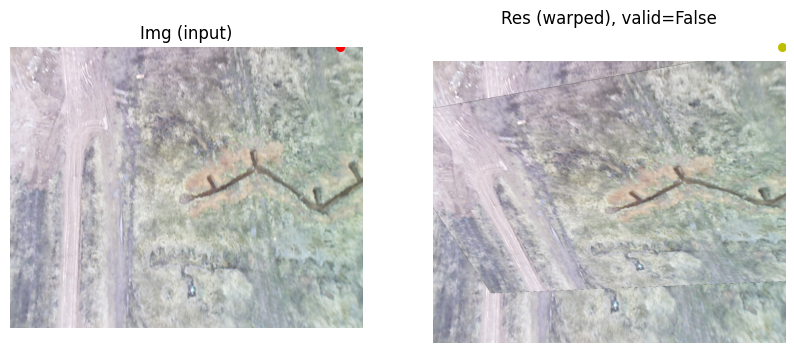

In [55]:
import matplotlib.pyplot as plt
import torch
import kornia as K

def show_homography_point(Img, Res, Warp, Mask, u, v, b_idx=0):
    """
    Img, Res: [B, C, H, W]       torch.Tensor
    Warp:    [B, 1, 3, 3] или [B, 3, 3]
    Mask:    [B, H, W]           валидные пиксели на Res
    u, v:    координаты (x=u, y=v) на Img
    """
    # Приведём Warp к [B,3,3]
    if Warp.dim() == 4:
        Warp = Warp[:, 0]  # [B,3,3]

    img0 = Img[b_idx].detach().cpu()    # [C,H,W]
    img1 = Res[b_idx].detach().cpu()
    H    = Warp[b_idx].detach().cpu()   # [3,3]
    mask = Mask[b_idx].detach().cpu()   # [H,W] (для Res)

    H_res, W_res = mask.shape

    # Точка на первой картинке
    pts_src = torch.tensor([[[float(u), float(v)]]], dtype=torch.float32)  # [1,1,2]
    H_batch = H.unsqueeze(0)                                               # [1,3,3]
    pts_dst = K.geometry.transform_points(H_batch, pts_src)                # [1,1,2][web:2]
    x2, y2 = pts_dst[0, 0].tolist()

    print(f"Input point:  ({u:.1f}, {v:.1f})")
    print(f"Warped point: ({x2:.1f}, {y2:.1f})")

    # проверим, в пределах ли картинки и маски
    valid_dst = (
        0 <= x2 < W_res and
        0 <= y2 < H_res
    )
    if valid_dst:
        valid_mask = bool(mask[int(round(y2)), int(round(x2))])
    else:
        valid_mask = False

    print(f"Valid in mask: {valid_mask}")

    # В numpy для imshow: [H,W,C]
    img0_np = img0.permute(1, 2, 0).numpy()
    img1_np = img1.permute(1, 2, 0).numpy()

    # Рисуем
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

    # первая картинка
    ax0.imshow(img0_np)
    ax0.scatter([u], [v], c='r', s=30)
    ax0.set_title("Img (input)")
    ax0.axis("off")

    # вторая картинка
    ax1.imshow(img1_np)

    color = 'g' if valid_mask else 'y'
    ax1.scatter([x2], [y2], c=color, s=30)
    ax1.set_title(f"Res (warped), valid={valid_mask}")
    ax1.axis("off")

    plt.show()


show_homography_point(Img, Res, Warp, Mask, 1200, 0, 0)


In [56]:
import kornia as K

def __compute_gt(keypoints_0, keypoints_1, warp, mask, px_thresh):
    """
    keypoints_0: [B, M0, 2]  на Img
    keypoints_1: [B, N0, 2]  на Res
    warp:        [B, 1, 3, 3] или [B, 3, 3]  гомография Img->Res
    mask:        [B, H, W]    валидные пиксели на Res
    """
    # Приведём warp к [B,3,3]
    if warp.dim() == 4:
        warp = warp[:, 0]   # [B,3,3]

    B = keypoints_0.shape[0]
    gt_assignment_list = []
    gt_matches0_list = []
    gt_matches1_list = []

    for b in range(B):
        kps0 = keypoints_0[b]          # [M0, 2]
        kps1 = keypoints_1[b]          # [N0, 2]
        H    = warp[b].squeeze()       # [3, 3]
        V    = mask[b].squeeze()       # [H, W] или [1,H,W]

        if V.ndim == 3:
            V = V.squeeze(0)           # [H,W]

        V_H, V_W = V.shape

        # ---- 1) Проецируем keypoints_0 в пространство Res через гомографию ----
        # формат для Kornia: [B,N,2] -> [B,N,2]
        pts_src = kps0.unsqueeze(0).to(H.device)     # [1,M0,2]
        H_batch = H.unsqueeze(0)                     # [1,3,3]
        kps0_proj = K.geometry.transform_points(H_batch, pts_src)[0]  # [M0,2][web:2]

        # ---- 2) Фильтруем по границам и маске ----
        x = kps0_proj[:, 0]
        y = kps0_proj[:, 1]

        in_bounds = (x >= 0) & (x < V_W) & (y >= 0) & (y < V_H)
        valid = in_bounds.clone()

        if in_bounds.any():
            xi = x[in_bounds].long()
            yi = y[in_bounds].long()
            mask_valid = V[yi, xi] > 0.5
            valid[in_bounds] = mask_valid

        kps0_proj_valid = kps0_proj[valid]                  # [M_valid,2]
        idx0_valid = torch.nonzero(valid, as_tuple=False).squeeze(1)  # индексы в исходном kps0

        M0 = kps0.shape[0]
        N0 = kps1.shape[0]
        gt_matches0 = torch.full((M0,), -1, device=kps0.device, dtype=torch.long)
        gt_matches1 = torch.full((N0,), -1, device=kps0.device, dtype=torch.long)
        gt_assignment = torch.zeros((M0, N0), device=kps0.device, dtype=torch.float32)

        if kps0_proj_valid.numel() == 0 or N0 == 0:
            gt_assignment_list.append(gt_assignment)
            gt_matches0_list.append(gt_matches0)
            gt_matches1_list.append(gt_matches1)
            continue

        # ---- 3) NN по пиксельной дистанции до keypoints_1 ----
        dx = kps0_proj_valid[:, None, :] - kps1[None, :, :]   # [M_valid,N0,2]
        d2 = (dx ** 2).sum(-1)                                # [M_valid,N0]
        min_d2, nn_j = d2.min(dim=1)                          # [M_valid]

        good = min_d2.sqrt() < px_thresh
        if good.sum() == 0:
            gt_assignment_list.append(gt_assignment)
            gt_matches0_list.append(gt_matches0)
            gt_matches1_list.append(gt_matches1)
            continue

        k0_good = idx0_valid[good]        # [G]
        k1_good = nn_j[good]              # [G]
        distances = min_d2[good].sqrt()   # [G]

        # ---- 4) Оставляем только один лучший match для каждого k1 ----
        if len(k1_good) > 0:
            best_mask = torch.zeros_like(k1_good, dtype=torch.bool)
            unique_k1, inverse_indices = torch.unique(k1_good, return_inverse=True)

            for uniq_idx in range(len(unique_k1)):
                matches_for_k1 = (inverse_indices == uniq_idx)
                if matches_for_k1.sum() > 0:
                    best_idx_in_group = distances[matches_for_k1].argmin()
                    global_idx = torch.nonzero(matches_for_k1, as_tuple=False)[best_idx_in_group].item()
                    best_mask[global_idx] = True

            k0_good = k0_good[best_mask]
            k1_good = k1_good[best_mask]

        gt_matches0[k0_good] = k1_good
        gt_matches1[k1_good] = k0_good
        gt_assignment[k0_good, k1_good] = 1.0

        gt_assignment_list.append(gt_assignment)
        gt_matches0_list.append(gt_matches0)
        gt_matches1_list.append(gt_matches1)

    gt = {
        "gt_assignment": torch.stack(gt_assignment_list, dim=0),
        "gt_matches0": torch.stack(gt_matches0_list, dim=0),
        "gt_matches1": torch.stack(gt_matches1_list, dim=0),
    }
    return gt




gt = __compute_gt(keypoints_0, keypoints_1, Warp, Mask, 1)

In [57]:
H_b = Warp[0].squeeze().cpu()
H0, W0 = Img.shape[-2:]
corners0 = torch.tensor([[0,0], [W0-1,0], [0,H0-1], [W0-1,H0-1]], dtype=torch.float32)
ones = torch.ones((4,1))
c0_h = torch.cat([corners0, ones], 1)
c1_h = (H_b @ c0_h.T).T
c1 = c1_h[:, :2] / c1_h[:, 2:3]
print("corners1:", c1)

corners1: tensor([[-218.1522,  209.8443],
        [1400.3271,  -76.1803],
        [ 210.2896,  842.0674],
        [1433.9531,  792.3325]])


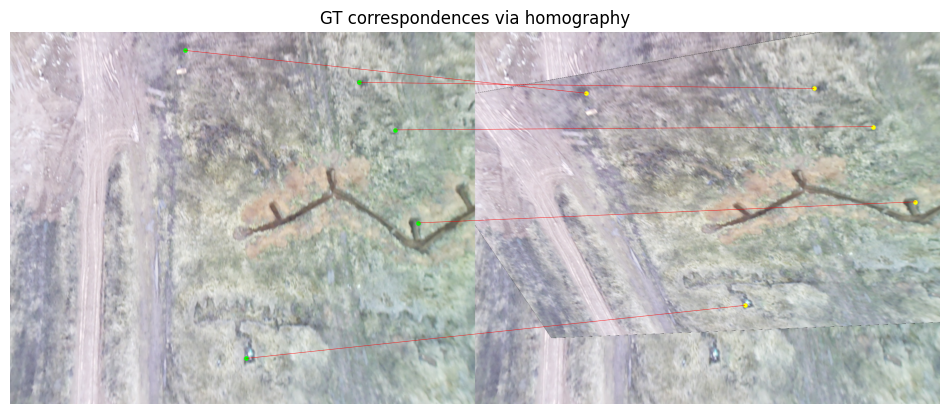

In [58]:
import matplotlib.pyplot as plt

b = 0  # индекс в батче, который хотим посмотреть

# изображения из батча (Img, Res: [B, C, H, W] в [0,1] или [0,255])
img0_b = Img[b].detach().cpu()
img1_b = Res[b].detach().cpu()

# keypoints и GT-матчи для этого элемента
kps0_b = keypoints_0[b].detach().cpu()                  # [M, 2]
kps1_b = keypoints_1[b].detach().cpu()                  # [N, 2]
matches0_b = gt["gt_matches0"][b].detach().cpu()        # [M]

# оставляем только действительно заматченные точки
valid_m = matches0_b >= 0
idx0 = torch.nonzero(valid_m, as_tuple=False).squeeze(1)  # индексы в kps0_b
idx1 = matches0_b[valid_m]                                # соответствующие индексы в kps1_b

pts0 = kps0_b[idx0]   # [K, 2]
pts1 = kps1_b[idx1]   # [K, 2]

def to_hwc(img):
    # [C, H, W] -> [H, W, C]
    if img.ndim == 3:
        return img.permute(1, 2, 0).float() / (255.0 if img.max() > 1.5 else 1.0)
    return img

img0_vis = to_hwc(img0_b)
img1_vis = to_hwc(img1_b)

# склеиваем изображения по ширине
H, W0, _ = img0_vis.shape
W1 = img1_vis.shape[1]
canvas = torch.zeros((H, W0 + W1, 3), dtype=img0_vis.dtype)
canvas[:, :W0] = img0_vis
canvas[:, W0:] = img1_vis

plt.figure(figsize=(12, 6))
plt.imshow(canvas)

# точки из первой картинки как есть,
# точки из второй — со сдвигом по x на ширину первой
offset = torch.tensor([W0, 0.0])
pts0_plot = pts0
pts1_plot = pts1 + offset

# рисуем линии соответствий
for p0, p1 in zip(pts0_plot, pts1_plot):
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]], 'r-', linewidth=0.4, alpha=0.7)

# сами ключевые точки
plt.scatter(pts0_plot[:, 0], pts0_plot[:, 1], s=5, c='lime')
plt.scatter(pts1_plot[:, 0], pts1_plot[:, 1], s=5, c='yellow')

plt.axis('off')
plt.title('GT correspondences via homography')
plt.show()
